# Gaussian Processes for EHT Gain Noise and Polarization
---
This notebook analyzes Gaussian random fields (processes) for gain-noise and polarization EHT imaging.

**Note the 'dev' branch of ehtim is needed.**

In [1]:
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
import os
import time as ttime
from  scipy.spatial import distance
from pynoisy.eht_functions import load_sgra_obs
import ehtim.const_def as ehc
from ehtim.observing import obs_helpers as obsh
from ehtim.caltable import Caltable
from scipy.interpolate import interp1d
from ehtim.imaging import starwarps as sw
from mpl_toolkits.axes_grid1 import make_axes_locatable
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

Welcome to eht-imaging! v  1.1.1


In [11]:
"""
Function definitions
"""
def rbf_kernel_covariance(xa, xb, sigma=1):
    """Exponentiated quadratic distance"""
    xa = np.expand_dims(xa, 1) if xa.ndim==1 else xa
    xb = np.expand_dims(xb, 1) if xb.ndim==1 else xb
    norm = -0.5 * distance.cdist(xa, xb, 'sqeuclidean') / sigma**2
    return np.exp(norm)

def plot_realizations(ax, x, y):
    """Plot GP realizations"""
    for i in range(y.shape[0]):
        ax.plot(x, y[i], linestyle='-', marker='o', markersize=3)
    ax.set_xlabel('$x$', fontsize=13)
    ax.set_ylabel('$y = f(x)$', fontsize=13)
    ax.set_xlim([x.min(), x.max()])
    
def get_gain_table(obs, gain_constant, gain_mult, seed, site):
    stabilize_scan_phase = True
    stabilize_scan_amp = True
    phasecal = False
    obs_sgra = obs.copy()
    times = obs_sgra.data['time']
    times_stable_phase = times.copy()
    times_stable_amp = times.copy()
    times_stable = times.copy()
    if stabilize_scan_phase is True or stabilize_scan_amp is True:
        scans = obs_sgra.scans
        if np.all(scans) is None or len(scans) == 0:
            obs_scans = obs.copy()
            obs_scans.add_scans()
            scans = obs_scans.scans
        for j in range(len(times_stable)):
            for scan in scans:
                if scan[0] <= times_stable[j] and scan[1] >= times_stable[j]:
                    times_stable[j] = scan[0]
                    break
    if stabilize_scan_phase is True:
        times_stable_phase = times_stable.copy()
    if stabilize_scan_amp is True:
        times_stable_amp = times_stable.copy()

    gains = np.sqrt(np.abs(np.fromiter((
        (1.0 + gain_constant) *
        (1.0 + gain_mult * obsh.hashrandn(site, 'gain', str(time), str(gain_mult), seed))
        for time in times_stable_amp
    ), float)))

    if not phasecal:
        phase = np.fromiter((2 * np.pi * obsh.hashrand(site, 'phase', time, seed)
                             for time in times_stable_phase), float)
        gains = gains * np.exp(1j*phase)
    return np.array([np.array((time, gain, gain), dtype=ehc.DTCAL) for time, gain in zip(times_stable_amp, gains)])

def get_gain_GP(obs, sigma_t, gain_constant, gain_mult, seed, site):
    stabilize_scan_phase = True
    stabilize_scan_amp = True
    phasecal = False
    obs_sgra = obs.copy()
    times = obs_sgra.data['time']
    times_stable_phase = times.copy()
    times_stable_amp = times.copy()
    times_stable = times.copy()
    if stabilize_scan_phase is True or stabilize_scan_amp is True:
        scans = obs_sgra.scans
        if np.all(scans) is None or len(scans) == 0:
            obs_scans = obs.copy()
            obs_scans.add_scans()
            scans = obs_scans.scans
        for j in range(len(times_stable)):
            for scan in scans:
                if scan[0] <= times_stable[j] and scan[1] >= times_stable[j]:
                    times_stable[j] = scan[0]
                    break

    if stabilize_scan_phase is True:
        times_stable_phase = times_stable.copy()
    if stabilize_scan_amp is True:
        times_stable_amp = times_stable.copy()

    scans_start = scans[:,0]
    cov = rbf_kernel_covariance(scans_start, scans_start, sigma_t)  
    cov *= 1.0 / cov.sum(axis=0)
    gains = np.sqrt(np.abs(
        (1 + gain_constant) * (1 + gain_mult * np.random.multivariate_normal(
            np.zeros(len(scans_start)), cov, check_valid='ignore'))))
    gain_interpolateor = interp1d(scans_start, gains, kind='zero')
    gains = gain_interpolateor(times_stable_amp)
    
    if not phasecal:
        phase = np.fromiter((2 * np.pi * obsh.hashrand(site, 'phase', time, seed)
                             for time in times_stable_phase), float)
        gains = gains * np.exp(1j*phase)

    return np.array([np.array((time, gain, gain), dtype=ehc.DTCAL) for time, gain in zip(times_stable_amp, gains)])
    
def compare_caltables(obs, gain_offset, gainp, sigma_t, site):
    
    goff = gain_offset[site]
    gain_mult = gainp[site]
    seed = str(ttime.time())
    gain_constant = goff * obsh.hashrandn(site, 'gain', str(goff), seed)
    
    # Enforce mean gain < 1
    gain_constant = -np.abs(gain_constant)
    
    datatables = {
        'Original': get_gain_table(obs,gain_constant, gain_mult, seed, site),
        'GP': get_gain_GP(obs, sigma_t, gain_constant, gain_mult, seed, site)
    }
    caltable = Caltable(obs_sgra.ra, obs_sgra.dec, obs_sgra.rf, obs_sgra.bw, datatables, 
                        obs_sgra.tarr, source=obs_sgra.source, mjd=obs_sgra.mjd, timetype=obs_sgra.timetype)
    return caltable

## Gaussian Proccess sampling

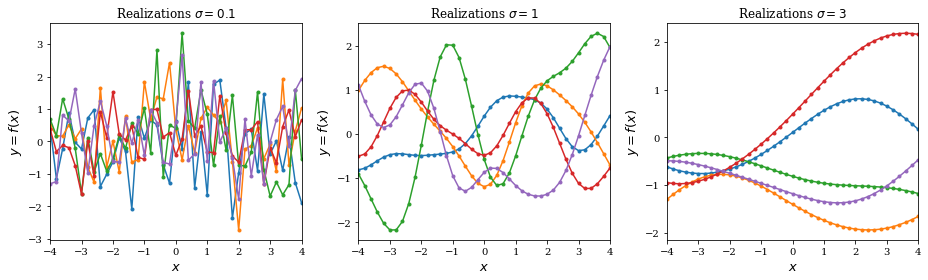

In [4]:
num_samples = 41
num_functions = 5  
x = np.expand_dims(np.linspace(-4, 4, num_samples), 1)

sigmas = [0.1, 1, 3]

fig, axes = plt.subplots(1, 3, figsize=(13,4))
for sigma, ax in zip(sigmas, axes):
    cov = rbf_kernel_covariance(x, x, sigma)  
    y = np.random.multivariate_normal(mean=np.zeros(num_samples), cov=cov, size=num_functions)
    plot_realizations(ax, x, y)
    ax.set_title(r'Realizations $\sigma={}$'.format(sigma))

plt.tight_layout()

## EHT Gain noise

In [9]:
"""
Load SgrA obs and make noise-less observations of the movie
"""
ehtim_home = '/home/aviad/Code/eht-imaging/'
uvfits_path = 'SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_LMTcal_10s.uvfits'
obs_sgra = load_sgra_obs(ehtim_home, uvfits_path)
movie_path = os.path.join(ehtim_home, 'SgrA/synthetic_data_SGRA_3599_lo/dataset3.0/ring_model/ring_model_fiducial2_angle60.0_radius19.0_rotationcw_eps0.1_dur0.2_amp0.4_tau1.0_lam0.5_tensor_ratio0.1_scattered.hdf5')
movie = eh.movie.load_hdf5(movie_path)
obs = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_LMTcal_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


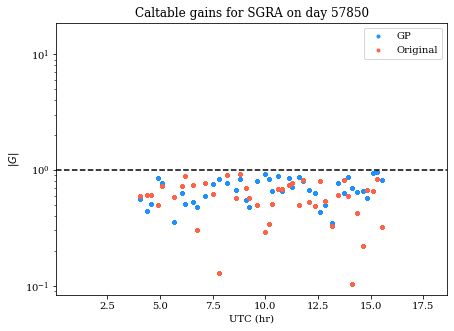

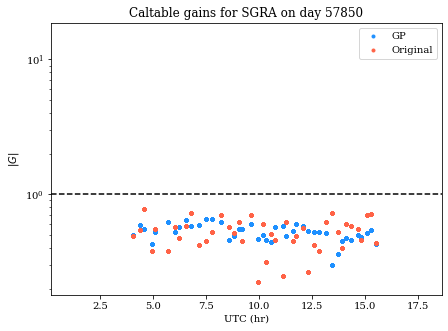

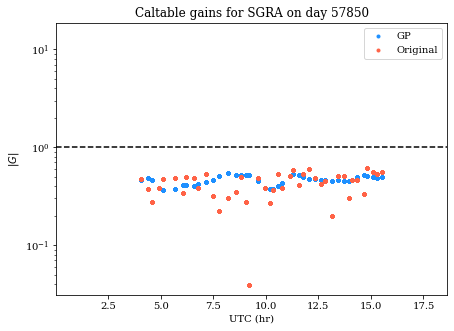

In [12]:
"""
Focus on LMT gains
"""
# the standard deviation of the absolute gain of each telescope from a gain of 1
gain_offset = {'AA':0.15, 'AP':0.15, 'AZ':0.15, 'LM':0.6, 'PV':0.15, 'SM':0.15, 'JC':0.15, 'SP':0.15, 'SR':0.0} 

# the standard deviation of gain differences over the observation at each telescope
gainp = {'AA':0.05, 'AP':0.05, 'AZ':0.05, 'LM':0.5, 'PV':0.05, 'SM':0.05, 'JC':0.05, 'SP':0.15, 'SR':0.0} 

caltables = [
    compare_caltables(obs_sgra, gain_offset, gainp, sigma_t=0.1, site='LM'),
    compare_caltables(obs_sgra, gain_offset, gainp, sigma_t=0.25, site='LM'),
    compare_caltables(obs_sgra, gain_offset, gainp, sigma_t=0.5, site='LM'),
]

%matplotlib inline
for table in caltables:
    plt.figure(figsize=(7,5));
    table.plot_gains([], axis=plt.gca(), gain_type='amp', pol='L')

## Polarization

In [13]:
def gen_dolp_aolp_images(powerDropoff=2.0, covfrac=0.4, max_dolp=0.75, circpolfrac=0.01, seed=1):

    # IMAGE PARAMETERS
    fov = 150.0 * eh.RADPERUAS  #field of view of the reconstructed image
    npixels = 50                #number of pixels in the x and y dimension to reconstruct
    source = 'M87'
    ra = 12.513728717168174
    dec = 12.39112323919932
    rf = 230000000000.0
    radius = 21*eh.RADPERUAS # the radius of the ring
    width = 10*eh.RADPERUAS # the width of the ring
    nonun_frac_stokesi = 0.5 # defines how much brighter the brighter location is on the ring
    fracpol = 0.4 # fractional polarization on model image
    compact_zbl = 0.8
    theta_nonun_stokesi = 270 # defines the angle of the brightest location


    empty = eh.image.make_empty(npixels, fov, ra, dec, rf=rf, source=source)


    theta_nonun_stokesi_rad = theta_nonun_stokesi * np.pi/180
    stokesI = empty.add_ring_m1(compact_zbl, compact_zbl*nonun_frac_stokesi, 
                                radius, theta_nonun_stokesi_rad, width)


    theta_nonun_stokesqu_rad = theta_nonun_stokesqu * np.pi/180
    
    
    np.random.seed(seed)
    flat = empty.copy()
    flat.imvec = np.ones(empty.imvec.shape)
    imCov =  sw.gaussImgCovariance_2(flat, powerDropoff=powerDropoff, frac=covfrac)

    dolp = empty.copy()
    rho = np.abs(np.random.multivariate_normal(empty.imvec, imCov))
    dolp.imvec = max_dolp * (rho - rho.min())/(rho.max() - rho.min())
    
    aolp = empty.copy()
    psi = np.random.multivariate_normal(empty.imvec, imCov)
    aolp.imvec = 2 * np.pi * (psi - psi.min())/(psi.max() - psi.min()) - np.pi 
    
    circpol = empty.copy()
    chi = np.random.multivariate_normal(empty.imvec, imCov)
    circpol.imvec = 2 * circpolfrac * (chi - chi.min())/(chi.max() - chi.min()) - circpolfrac 
    
    fullStokes = stokesI.copy()
    fullStokes.imvec = stokesI.imvec 
    fullStokes.qvec = stokesI.imvec * dolp.imvec * np.cos(aolp.imvec) * np.cos(circpol.imvec)
    fullStokes.uvec = stokesI.imvec * dolp.imvec * np.sin(aolp.imvec) * np.cos(circpol.imvec) 
    fullStokes.vvec = stokesI.imvec * dolp.imvec * np.sin(circpol.imvec)
    fullStokes.dop = np.sqrt(fullStokes.qvec**2 + fullStokes.uvec**2 + fullStokes.vvec**2) / (fullStokes.ivec + 1e-10)
    fullStokes.dolp = np.sqrt(fullStokes.qvec**2 + fullStokes.uvec**2) / (fullStokes.ivec + 1e-10)
    fullStokes.aolp = 0.5*np.arctan2(fullStokes.uvec, fullStokes.qvec)
    fullStokes.aop = 0.5*np.arctan2(fullStokes.vvec, np.sqrt(fullStokes.qvec**2 + fullStokes.uvec**2))
    return fullStokes

def gen_pol_images(powerDropoff=2.0, covfrac=0.4, nonun_frac_stokesqu=0.4, theta_nonun_stokesqu=350, 
                   compact_zbl_frac=0.5, circpolfrac=0.01, seed=1):

    # =========== PARAMETERS =========== #

    # IMAGE PARAMETERS
    fov = 150.0 * eh.RADPERUAS  #field of view of the reconstructed image
    npixels = 50                #number of pixels in the x and y dimension to reconstruct
    source = 'M87'
    ra = 12.513728717168174
    dec = 12.39112323919932
    rf = 230000000000.0
    radius = 21*eh.RADPERUAS # the radius of the ring
    width = 10*eh.RADPERUAS # the width of the ring
    nonun_frac_stokesi = 0.5 # defines how much brighter the brighter location is on the ring
    fracpol = 0.4 # fractional polarization on model image
    compact_zbl = 0.8
    theta_nonun_stokesi = 270 # defines the angle of the brightest location


    empty = eh.image.make_empty(npixels, fov, ra, dec, rf=rf, source=source)


    theta_nonun_stokesi_rad = theta_nonun_stokesi * np.pi/180
    stokesI = empty.add_ring_m1(compact_zbl, compact_zbl*nonun_frac_stokesi, radius, theta_nonun_stokesi_rad, width)


    theta_nonun_stokesqu_rad = theta_nonun_stokesqu * np.pi/180
    stokesQU = empty.add_ring_m1(compact_zbl_frac*compact_zbl, compact_zbl_frac*compact_zbl*nonun_frac_stokesqu, radius, theta_nonun_stokesqu_rad, width)


    np.random.seed(seed)
    flat = empty.copy()
    flat.imvec = np.ones(empty.imvec.shape)
    imCov =  sw.gaussImgCovariance_2(flat, powerDropoff=powerDropoff, frac=covfrac)

    stokesQ = empty.copy()
    stokesQ.imvec = np.random.multivariate_normal(empty.imvec, imCov) * stokesQU.imvec


    stokesU = empty.copy()
    stokesU.imvec = np.random.multivariate_normal(empty.imvec, imCov) * stokesQU.imvec
    
    stokesV = empty.copy()
    stokesV.imvec = np.random.multivariate_normal(empty.imvec, imCov) * stokesQU.imvec * circpolfrac


    compare = empty.copy()
    compare.imvec = (np.sqrt(stokesQ.imvec**2 + stokesU.imvec**2)) / stokesI.imvec


    #stokesI.display()
    #stokesQU.display()
    #stokesQ.display()
    #stokesU.display()
    #compare.display()
    #pol = empty.copy()
    #pol.imvec = np.sqrt(stokesQ.imvec**2 + stokesU.imvec**2)
    #pol.display()

    fullStokes = stokesI.copy()
    fullStokes.imvec = stokesI.imvec
    fullStokes.qvec = stokesQ.imvec
    fullStokes.uvec = stokesU.imvec
    fullStokes.vvec = stokesV.imvec
    fullStokes.dop = np.sqrt(fullStokes.qvec**2 + fullStokes.uvec**2 + fullStokes.vvec**2) / (fullStokes.ivec + 1e-10)
    fullStokes.dolp = np.sqrt(fullStokes.qvec**2 + fullStokes.uvec**2) / (fullStokes.ivec + 1e-10)
    fullStokes.aolp = 0.5*np.arctan2(fullStokes.uvec, fullStokes.qvec)
    fullStokes.aop = 0.5*np.arctan2(fullStokes.vvec, np.sqrt(fullStokes.qvec**2 + fullStokes.uvec**2))
    #fullStokes.display(plotp=True, nvec=40)
    
    return fullStokes

def plot_stokes(stokes):
    fig, axes = plt.subplots(1,4, figsize=(10,4))
    stokes.display(pol='I', axis=axes[0], has_title=False, cbar_orientation='horizontal')
    plt.axis('off')
    stokes.display(pol='Q', axis=axes[1], has_title=False, cbar_orientation='horizontal')
    plt.axis('off')
    stokes.display(pol='U', axis=axes[2], has_title=False, cbar_orientation='horizontal')
    plt.axis('off')
    stokes.display(pol='v', axis=axes[3], has_title=False, cbar_orientation='horizontal')
    plt.axis('off')

    fig, axes = plt.subplots(1, 4, figsize=(10,4))
    im = axes[0].imshow(stokes.dop.reshape(50,50))
    axes[0].set_title('DOP')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    plt.colorbar(im, cax=cax, orientation='horizontal')
    im = axes[1].imshow(stokes.dolp.reshape(50,50))
    axes[1].set_title('DOLP')
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    plt.colorbar(im, cax=cax, orientation='horizontal')
    im = axes[2].imshow(stokes.aolp.reshape(50,50))
    axes[2].set_title('AOLP')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    plt.colorbar(im, cax=cax, orientation='horizontal')
    im = axes[3].imshow(stokes.aop.reshape(50,50))
    axes[3].set_title('AOP')
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes("bottom", size="5%", pad=0.3)
    plt.colorbar(im, cax=cax, orientation='horizontal')

In [14]:
nonun_frac_stokesqu = 0.8
covfrac = 0.4
compact_zbl_frac=0.4
theta_nonun_stokesqu = 225
seed = 3
powerDropoff = 2.0

stokes_orig = gen_pol_images(
    powerDropoff=powerDropoff, covfrac=covfrac, nonun_frac_stokesqu=nonun_frac_stokesqu, 
    theta_nonun_stokesqu=theta_nonun_stokesqu, compact_zbl_frac=compact_zbl_frac, seed=seed
)
stokes_new = gen_dolp_aolp_images(powerDropoff=powerDropoff, covfrac=covfrac, seed=seed)

<IPython.core.display.Javascript object>


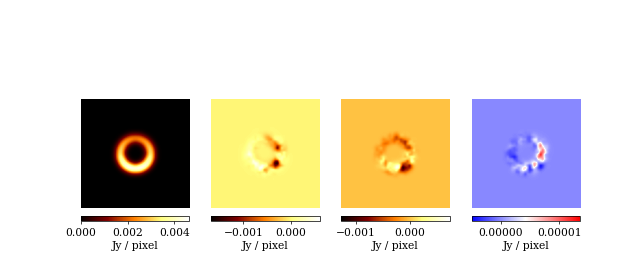

<IPython.core.display.Javascript object>


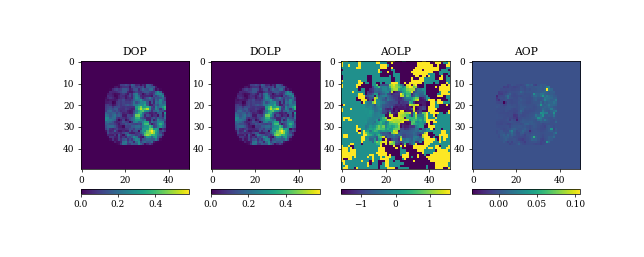

In [16]:
%matplotlib notebook
plot_stokes(stokes_orig)

<IPython.core.display.Javascript object>


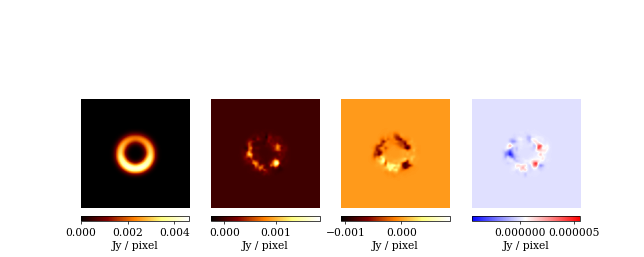

<IPython.core.display.Javascript object>


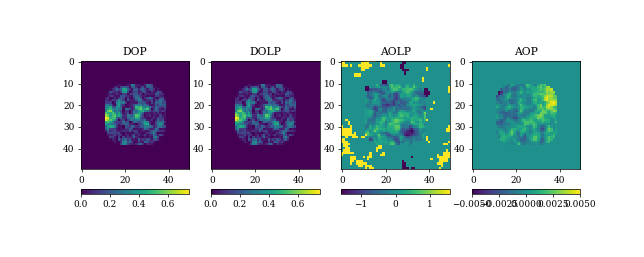

In [17]:
%matplotlib notebook
plot_stokes(stokes_new)